<a href="https://colab.research.google.com/github/MASSIMOQSELLA/MyAKarpathyMicrogradTest/blob/main/MyAndrejCarpathyMicrogradEngineCopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.6 -> x | -1.5 -> y | 0.10000000000000009 -> s | 0.050000000000000044 -> p | 0.050000000000000044 r
Value(data=0.050000000000000044, grad=1, nm=r) da reversed topo, qui sottoposta a _backward
Value(data=0.050000000000000044, grad=1, nm=p) da reversed topo, qui sottoposta a _backward
Value(data=0.5, grad=0.10000000000000009, nm=z) da reversed topo, qui sottoposta a _backward
Value(data=0.10000000000000009, grad=0.5, nm=s) da reversed topo, qui sottoposta a _backward
Value(data=-1.5, grad=0.5, nm=y) da reversed topo, qui sottoposta a _backward
Value(data=1.6, grad=0.5, nm=x) da reversed topo, qui sottoposta a _backward


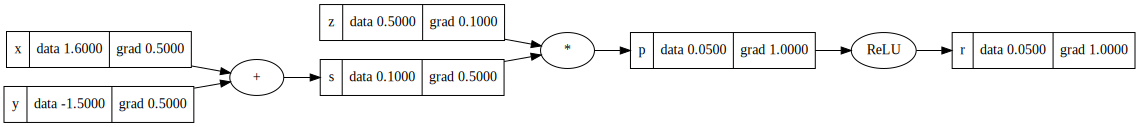

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from graphviz import Digraph
import pdb

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', _nm=''):
        if not isinstance(data, (int, float)):
          raise TypeError("data must be a scalar (int or float)")
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self._nm = _nm

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
#        print(topo, 'topo initialization')
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
#                print(visited, 'visited')
                for child in v._prev:
#                    print(child, 'child of', v._nm, 'by op', v._op)
#                    print(topo, 'topo before append')
                    build_topo(child)
                topo.append(v)
#                print(topo, 'topo after append')
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            print(v, 'da reversed topo, qui sottoposta a _backward')
            v._backward()
#        print(topo, 'final topo')

    def __neg__(self): #-self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, nm={self._nm})"


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %.4s | data %.4f | grad %.4f }" % (n._nm, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# a very simple example
x = Value(1.6,_nm='x')
y = Value(-1.5,_nm='y')
z = Value(0.5,_nm='z')
s = (x + y);s._nm='s'
p = s * z;p._nm='p'
r = p.relu(); r._nm='r'
print (x.data, '->', x._nm, '|', y.data,'->', y._nm, '|', s.data, '->', s._nm, '|', p.data, '->', p._nm,'|', r.data, r._nm  )
r.backward()
draw_dot(r)
